In [1]:
#load data 

import pandas as pd
import pickle
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

trip_data_file = "data/trip_data_4.csv"
trip_fare_file = "data/trip_fare_4.csv"

trips = pd.read_csv(trip_data_file, nrows=100000)
fares = pd.read_csv(trip_fare_file, nrows=100000)

full_tripdata = pd.merge(left=trips,right=fares, how='left', left_on=['medallion',' hack_license',' vendor_id',' pickup_datetime'], right_on=['medallion',' hack_license',' vendor_id',' pickup_datetime'])
full_tripdata = full_tripdata.drop_duplicates()

/home/ma_emali/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
# Drop some un-wanted columns
full_tripdata = full_tripdata.drop(columns=['medallion',' hack_license',' vendor_id',' rate_code',' store_and_fwd_flag'])

In [22]:
#prepare time related column , weekday and hourofday
full_tripdata[" pickup_datetime"] = pd.to_datetime(full_tripdata[" pickup_datetime"])
full_tripdata[" dropoff_datetime"] = pd.to_datetime(full_tripdata[" dropoff_datetime"])

full_tripdata["weekday"] = full_tripdata[" pickup_datetime"].dt.dayofweek
full_tripdata["hourofday"] = full_tripdata[" pickup_datetime"].dt.hour


In [23]:
full_tripdata.describe()

,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,weekday,hourofday
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,2.162330,682.381720,3.092583,-72.853142,40.148271,-72.800308,40.082386,12.331998,0.428265,0.49829,1.324516,0.171536,14.754605,4.624960,10.25695
std,1.742334,461.783145,3.197229,9.050491,5.193093,10.572996,11.174743,9.714647,0.236299,0.02919,2.242804,1.020873,11.431332,0.495103,9.30205
min,1.000000,0.000000,0.000000,-75.316666,0.000000,-736.533330,-3113.277600,2.500000,0.000000,0.00000,0.000000,0.000000,3.000000,0.000000,0.00000
25%,1.000000,360.000000,1.150000,-73.993187,40.727672,-73.991905,40.726948,6.500000,0.500000,0.50000,0.000000,0.000000,8.000000,4.000000,1.00000
50%,1.000000,600.000000,2.050000,-73.984245,40.745390,-73.980835,40.748234,9.500000,0.500000,0.50000,1.000000,0.000000,11.300000,5.000000,7.00000
75%,3.000000,900.000000,3.790000,-73.969763,40.763062,-73.959595,40.766598,14.500000,0.500000,0.50000,2.000000,0.000000,17.262500,5.000000,22.00000
max,6.000000,7500.000000,54.380000,0.000000,404.816010,1428.738300,49.183331,350.000000,1.000000,0.50000,200.000000,19.800000,350.500000,6.000000,23.00000


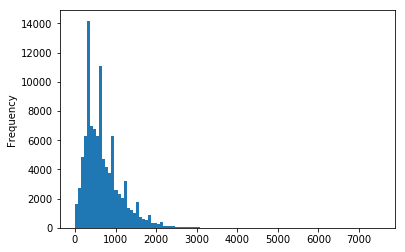

In [24]:
full_tripdata[' trip_time_in_secs'].plot.hist(bins=100)

In [25]:
#remove outliers
measuredata = pd.concat([np.log(full_tripdata[' trip_time_in_secs']+1), 
                         full_tripdata[' pickup_longitude'],
                         full_tripdata[' pickup_latitude'],
                         full_tripdata[' dropoff_longitude'],
                         full_tripdata[' fare_amount'],
                         full_tripdata[' tip_amount'],
                        ],axis=1)

#remove data out of two standard deviation
#full_tripdata = full_tripdata[(np.abs(stats.zscore(measuredata)) < 2).all(axis=1)]

full_tripdata = full_tripdata.loc[((full_tripdata[' pickup_longitude'] < -72.0) & (full_tripdata[' pickup_latitude'] > 30.0)) 
                                  # | ((full_tripdata[' dropoff_latitude'] < -72.0) & (full_tripdata[' dropoff_latitude'] > 30.0))]

In [26]:
full_tripdata.describe()
#full_tripdata.columns

,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,weekday,hourofday
count,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000
mean,2.166454,632.946057,2.590301,-73.980541,40.746910,-73.975699,40.748570,10.729811,0.435229,0.499973,1.082358,0.058842,12.806212,4.622050,10.306247
std,1.743342,370.125368,1.974000,0.029392,0.033722,0.031815,0.043128,5.702366,0.232129,0.003688,1.322938,0.559450,6.476497,0.495336,9.324038
min,1.000000,100.000000,0.000000,-75.316666,34.133331,-74.342140,40.577496,2.500000,0.000000,0.000000,0.000000,0.000000,3.500000,0.000000,0.000000
25%,1.000000,360.000000,1.150000,-73.993530,40.728977,-73.992203,40.728992,6.500000,0.500000,0.500000,0.000000,0.000000,8.000000,4.000000,1.000000
50%,1.000000,540.000000,1.970000,-73.984947,40.745941,-73.981682,40.748936,9.000000,0.500000,0.500000,0.900000,0.000000,11.000000,5.000000,7.000000
75%,3.000000,840.000000,3.460000,-73.972145,40.763126,-73.962593,40.766533,13.500000,0.500000,0.500000,1.900000,0.000000,16.000000,5.000000,22.000000
max,6.000000,2820.000000,11.620000,-71.300003,41.453693,-71.306664,49.183331,31.500000,1.000000,0.500000,5.800000,10.660000,42.830000,6.000000,23.000000


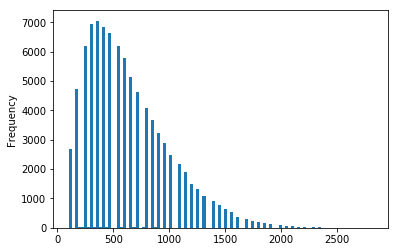

In [27]:
full_tripdata[' trip_time_in_secs'].plot.hist(bins=100)

In [28]:
#prepare location, use pre-trained k-mean model
model = pickle.load(open('location_cluster_kmean', 'rb'))
pickupLocations = full_tripdata.iloc[:,5:7]
#print pickupLocations.describe()
full_tripdata["pickupLoc"] = model.predict(pickupLocations.as_matrix())

dropoffLocations = full_tripdata.iloc[:,7:9]
full_tripdata["dropoffLoc"] = model.predict(dropoffLocations.as_matrix())
#print dropoffLocations.describe()

In [29]:
#drop all un-wanted columns
training = full_tripdata.drop(columns=[' pickup_datetime',
                                       ' dropoff_datetime',
                                       ' trip_distance',
                                       ' dropoff_longitude',
                                       ' dropoff_latitude',
                                       ' surcharge',
                                       ' mta_tax',
                                       ' tolls_amount',
                                       ' total_amount',
                                       ' passenger_count',
                                       ' payment_type',
                                       ' pickup_longitude',
                                       ' pickup_latitude'])
print training.columns
training.describe()

Index([u' trip_time_in_secs', u' fare_amount', u' tip_amount', u'weekday',
       u'hourofday', u'pickupLoc', u'dropoffLoc'],
      dtype='object')


,trip_time_in_secs,fare_amount,tip_amount,weekday,hourofday,pickupLoc,dropoffLoc
count,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000,91893.000000
mean,632.946057,10.729811,1.082358,4.622050,10.306247,23.611026,24.228995
std,370.125368,5.702366,1.322938,0.495336,9.324038,14.057593,14.019340
min,100.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,360.000000,6.500000,0.000000,4.000000,1.000000,11.000000,12.000000
50%,540.000000,9.000000,0.900000,5.000000,7.000000,23.000000,24.000000
75%,840.000000,13.500000,1.900000,5.000000,22.000000,37.000000,38.000000
max,2820.000000,31.500000,5.800000,6.000000,23.000000,49.000000,49.000000


In [30]:
#column data type change 
training['weekday'] = training['weekday'].astype('category')
training['hourofday'] = training['hourofday'].astype('category')
training['pickupLoc'] = training['pickupLoc'].astype('category')
training['dropoffLoc'] = training['dropoffLoc'].astype('category')

In [31]:
#training and result data split
X = training.iloc[:,3:]
Y_triptime = training.iloc[:,0]
Y_fare = training.iloc[:,1]
Y_tip = training.iloc[:,2]


In [32]:
#convert category data to one-hot embedding
X = pd.get_dummies(X)

In [33]:
#dump the prepaired data

pickle.dump(X,open("X","wb"))
pickle.dump(Y_fare,open("Y_fare","wb"))
pickle.dump(Y_tip,open("Y_tip","wb"))
pickle.dump(Y_triptime,open("Y_triptime","wb"))